In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy

In [3]:
SEED = 50
np.random.seed(SEED)
tf.random.set_seed(SEED)

GESTURES = ["forehand", "backhand", "idle"]
SAMPLES_PER_GESTURE = 30
NUM_GESTURES = len(GESTURES)

inputs = []
outputs = []

for gesture_index, gesture in enumerate(GESTURES):
    print(f"\nProcessing index {gesture_index} for gesture '{gesture}'.")

    df = pd.read_csv(f"./TT_DataCollector/{gesture}.csv")

    print(f"\tFile Shape: {df.shape}")
    print(f"\tColumns: {df.columns.tolist()}")

    required_columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'mX', 'mY', 'mZ']
    if not all(col in df.columns for col in required_columns):
        continue

    num_recordings = df.shape[0] // SAMPLES_PER_GESTURE
    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
    
    for i in range(num_recordings):
        index = i * SAMPLES_PER_GESTURE

        if index + SAMPLES_PER_GESTURE > df.shape[0]:
            continue

        X = df['aX'][index: index + SAMPLES_PER_GESTURE].values
        Y = df['aY'][index: index + SAMPLES_PER_GESTURE].values
        Z = df['aZ'][index: index + SAMPLES_PER_GESTURE].values

        gX = df['gX'][index: index + SAMPLES_PER_GESTURE].values
        gY = df['gY'][index: index + SAMPLES_PER_GESTURE].values
        gZ = df['gZ'][index: index + SAMPLES_PER_GESTURE].values

        mX = df['mX'][index: index + SAMPLES_PER_GESTURE].values
        mY = df['mY'][index: index + SAMPLES_PER_GESTURE].values
        mZ = df['mZ'][index: index + SAMPLES_PER_GESTURE].values
        
        tensor = np.vstack((X, Y, Z, gX, gY, gZ, mX, mY, mZ)).transpose()

        inputs.append(tensor)
        outputs.append(gesture_index)

inputs = np.array(inputs)
outputs = np.array(outputs)

print("\nFinal Data Shapes:")
print(f"\tInputs Shape: {inputs.shape}")
print(f"\tOutputs Shape: {outputs.shape}")



Processing index 0 for gesture 'forehand'.
	File Shape: (3000, 11)
	Columns: ['counter', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'mX', 'mY', 'mZ', 'label']
	There are 100 recordings of the forehand gesture.

Processing index 1 for gesture 'backhand'.
	File Shape: (3000, 11)
	Columns: ['Counter', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'mX', 'mY', 'mZ', 'label']
	There are 100 recordings of the backhand gesture.

Processing index 2 for gesture 'idle'.
	File Shape: (3000, 11)
	Columns: ['Counter', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'mX', 'mY', 'mZ', 'label']
	There are 100 recordings of the idle gesture.

Final Data Shapes:
	Inputs Shape: (300, 30, 9)
	Outputs Shape: (300,)


In [4]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.", f"{inputs_train.shape=}, {outputs_train.shape=}")

Data set randomization and splitting complete. inputs_train.shape=(180, 30, 9), outputs_train.shape=(180,)


In [5]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=inputs_train.shape[1:], name='input'),
    tf.keras.layers.GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_max_pooling1d (Glob  (None, 9)                 0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                320       
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 419 (1.64 KB)
Trainable params: 419 (1.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(
    x=inputs_train,
    y=outputs_train,
    validation_data=[inputs_validate, outputs_validate],
    batch_size=32,
    shuffle=True,
    epochs=30
)

Epoch 1/30
6/6 [==============================] - 1s 36ms/step - loss: 6.8591 - accuracy: 0.5611 - val_loss: 1.3279 - val_accuracy: 0.8167
Epoch 2/30
6/6 [==============================] - 0s 7ms/step - loss: 1.8655 - accuracy: 0.8278 - val_loss: 0.7860 - val_accuracy: 0.9333
Epoch 3/30
6/6 [==============================] - 0s 7ms/step - loss: 1.0432 - accuracy: 0.9333 - val_loss: 0.9214 - val_accuracy: 0.9500
Epoch 4/30
6/6 [==============================] - 0s 7ms/step - loss: 0.6203 - accuracy: 0.9611 - val_loss: 1.0730 - val_accuracy: 0.9500
Epoch 5/30
6/6 [==============================] - 0s 7ms/step - loss: 0.3679 - accuracy: 0.9778 - val_loss: 1.2231 - val_accuracy: 0.9500
Epoch 6/30
6/6 [==============================] - 0s 12ms/step - loss: 0.2609 - accuracy: 0.9722 - val_loss: 1.2680 - val_accuracy: 0.9500
Epoch 7/30
6/6 [==============================] - 0s 6ms/step - loss: 0.1969 - accuracy: 0.9667 - val_loss: 1.1582 - val_accuracy: 0.9500
Epoch 8/30
6/6 [================

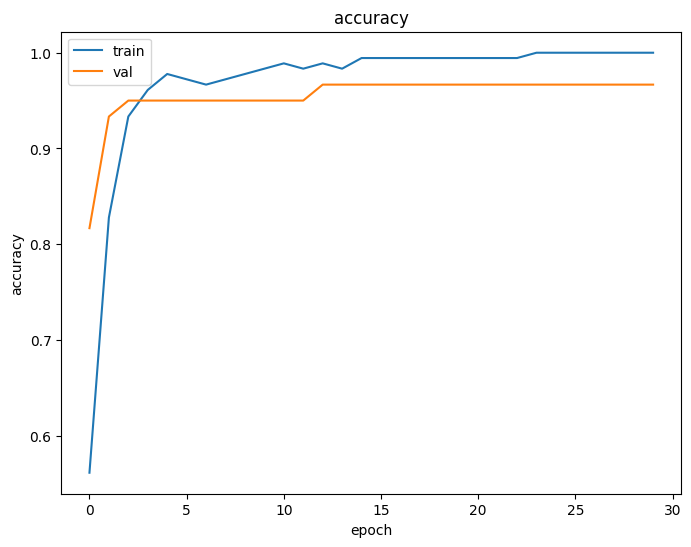

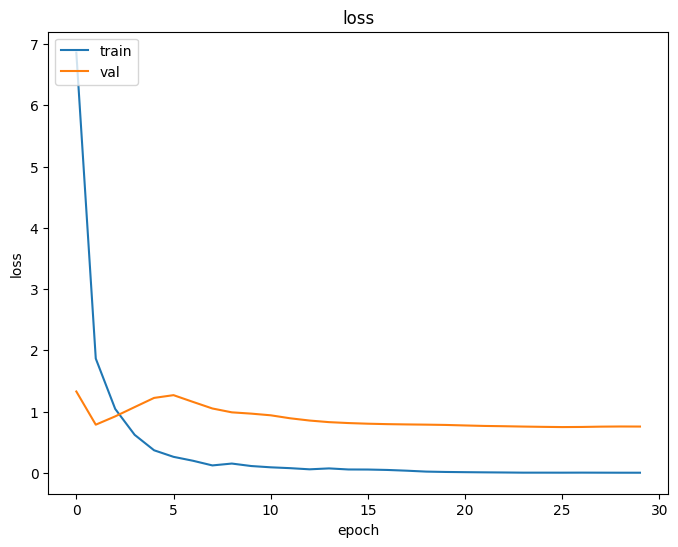

In [8]:
def plot_train_val_statistics(training_statistics, validation_statistics, statistics_name='accuracy'):
    plt.figure(figsize=(8, 6))
    plt.plot(training_statistics)
    plt.plot(validation_statistics)
    plt.title(statistics_name)
    plt.ylabel(statistics_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_train_val_statistics(history.history['accuracy'], history.history['val_accuracy'], 'accuracy')
plot_train_val_statistics(history.history['loss'], history.history['val_loss'], 'loss')

In [9]:
# Results on the test set
performance = model.evaluate(x=inputs_test, y=outputs_test)
print(''.join([f"{name}={value:.05f}  " for name, value in zip(model.metrics_names, performance)]))

2/2 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 1.0000
loss=0.00369  accuracy=1.00000  


2/2 [==============================] - 0s 3ms/step


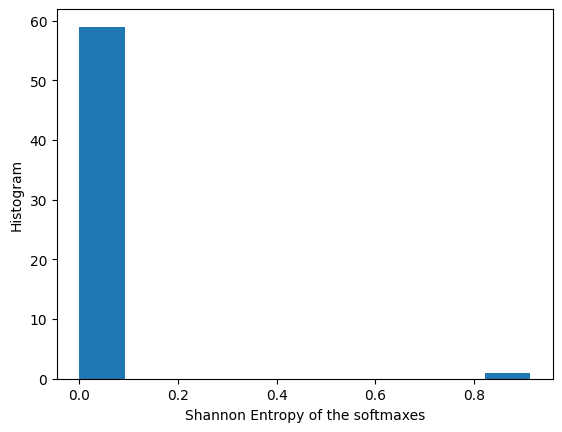

In [10]:
pred = model.predict(inputs_test)
H = entropy(pred, base=2, axis=1)
plt.hist(H, bins=10)
plt.xlabel("Shannon Entropy of the softmaxes")
plt.ylabel("Histogram")
plt.show()

In [11]:
def preprocess_custom_data(csv_file):
    df = pd.read_csv(csv_file, names=['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'mX', 'mY', 'mZ'], header=None)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)
    print(df.head)
    
    SAMPLES_PER_GESTURE = 30
    num_recordings = df.shape[0] // SAMPLES_PER_GESTURE

    inputs = []
    for i in range(num_recordings):
        index = i * SAMPLES_PER_GESTURE
        X = df['aX'][index: index + SAMPLES_PER_GESTURE].values
        Y = df['aY'][index: index + SAMPLES_PER_GESTURE].values
        Z = df['aZ'][index: index + SAMPLES_PER_GESTURE].values

        gX = df['gX'][index: index + SAMPLES_PER_GESTURE].values
        gY = df['gY'][index: index + SAMPLES_PER_GESTURE].values
        gZ = df['gZ'][index: index + SAMPLES_PER_GESTURE].values

        mX = df['mX'][index: index + SAMPLES_PER_GESTURE].values
        mY = df['mY'][index: index + SAMPLES_PER_GESTURE].values
        mZ = df['mZ'][index: index + SAMPLES_PER_GESTURE].values

        tensor = np.vstack((X, Y, Z, gX, gY, gZ, mX, mY, mZ)).transpose()
        inputs.append(tensor)

    return np.array(inputs)

custom_data = preprocess_custom_data("./TT_DataCollector/TestData.csv")

predictions = model.predict(custom_data)

predicted_classes = np.argmax(predictions, axis=1)
GESTURES = ["forehand", "backhand", "idle"]

predicted_labels = [GESTURES[i] for i in predicted_classes]

print("Predicted Gestures:", predicted_labels)

<bound method NDFrame.head of       aX    aY    aZ      gX      gY      gZ    mX     mY     mZ
1   0.19 -1.04  0.76  -71.35   -8.79   48.83  7.41  33.26 -37.32
2   0.33 -0.74  0.39  -79.71  -17.21   65.06  8.13  33.41 -36.77
3   0.29 -0.77  0.42  -63.96  -34.06   90.94  7.73  34.27 -36.43
4   0.26 -0.96  0.46  -54.99  -21.79  116.88  7.71  34.00 -36.19
5   0.29 -0.81  0.38  -86.18  -42.97  110.72  6.81  34.12 -35.51
6   0.37 -1.09  0.32  -88.81  -76.48   90.27  5.20  33.76 -37.84
7   0.55 -1.44  0.23 -102.17 -101.26   83.86  3.23  32.03 -40.50
8   0.51 -1.39  0.22 -112.12 -106.81   77.39  5.02  31.27 -43.32
9   0.54 -1.05  0.22 -116.03 -124.39   48.16  6.73  25.70 -45.90
10  0.35 -1.09  0.29 -137.45 -150.94    4.15  5.04  19.79 -47.24
11  0.29 -0.72  0.23 -143.74  -88.99   -7.14  1.06  14.58 -49.02
12  0.12 -0.69  0.08 -122.62  -17.64  -26.37 -3.25   8.18 -43.80
13 -0.28 -0.43  0.21  -72.57  152.83 -161.68 -6.03   2.06 -41.11
14 -0.57  0.13  0.28  129.58  -10.38   31.25 -4.98  -3.55 -3

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open("gesture_model.tflite", "wb").write(tflite_model)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open("gesture_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\yashn\AppData\Local\Temp\tmpnh12822k\assets


INFO:tensorflow:Assets written to: C:\Users\yashn\AppData\Local\Temp\tmpnh12822k\assets


INFO:tensorflow:Assets written to: C:\Users\yashn\AppData\Local\Temp\tmp6swwfvyq\assets


INFO:tensorflow:Assets written to: C:\Users\yashn\AppData\Local\Temp\tmp6swwfvyq\assets


3688

In [13]:
with open('gesture_model_quantized.tflite', 'rb') as f:
    tflite_model_data = f.read()

header_file = 'model.h'
with open(header_file, 'w') as h_file:
    h_file.write('#ifndef MODEL_H\n')
    h_file.write('#define MODEL_H\n\n')
    h_file.write('unsigned char gesture_model_quantized_tflite[] = {\n')
    
    h_file.write(', '.join([f'0x{byte:02x}' for byte in tflite_model_data]))
    
    h_file.write('\n};\n\n')
    h_file.write('#endif  // MODEL_H\n')

print(f'Header file {header_file} has been created.')


Header file model.h has been created.
